## Testing the built Classes and Environment
-----

In [1]:
import tensorflow as tf
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("NO GPU FOUND!")

In [2]:
from importlib import reload

from src.data.states import get_body_state

from src.components import sunsystem; sunsystem = reload(sunsystem)
from src.components import solver; solver = reload(solver)
from src.components import targets; targets = reload(targets)
from src.components import walkers; walkers = reload(walkers)

In [3]:
# Initial State
from datetime import date
from astropy.time import Time
now = date.today()
time = Time(now.strftime(r'%Y-%m-%d %H:%M'), scale="utc")
walker_name = "mars"

walker_position, walker_velocity = get_body_state(walker_name, time).values()

#### Testing the `Walker` / `SunSystem` / `Solver` Composition
-----

In [4]:
system = sunsystem.SunSystem(["earth"]) # "jupiter"
walker = walkers.Walker(walker_position, walker_velocity, system, name=f"walker ({walker_name})")
solver = solver.Solver()

In [173]:
for _ in range(600):
    walker.propagate(solver)
    system.propagate()

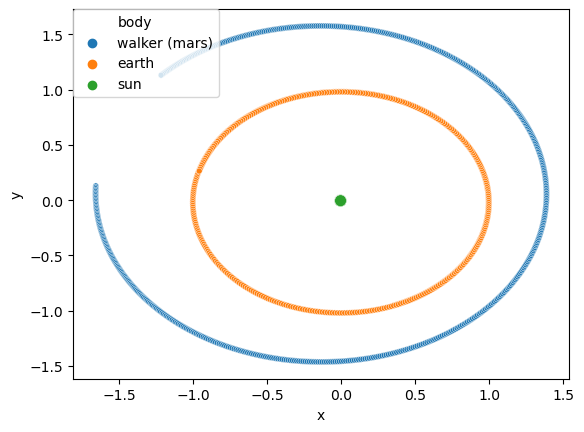

In [174]:
plotter = src.Plotter(walker=walker, system=system)
fig = plotter.draw(mode="2d")

#### Validating the `WalkerSystemEnv`

-----

In [175]:
from tf_agents.environments import validate_py_environment
from tf_agents.environments import tf_environment, tf_py_environment

In [176]:
walker_position = tf.constant([0., 0., 1.], dtype=tf.float32)
walker_velocity = tf.constant([0., 0., 0.], dtype=tf.float32)

In [177]:
system = src.SunSystem(["earth", "jupiter"], add_sun=False)
walker = src.Walker(walker_position, walker_velocity, mass=1., name=f"walker ({walker_name})")
solver = src.Solver()
target = tf.constant([0., 0., 2.], dtype=tf.float32)

In [178]:
class Env(
    src.env.WalkerSystemEnv,
    src.env.OneDimDiscreteAction,               # src.env: ContinuousAction, DiscreteAction, OneDimDiscreteAction
    src.env.StateAndDiffObservation             # src.env: StateAndDiffObservation, GravityObservation, AllPositionsObservation
): ...

In [179]:
env = Env(walker, system, solver, target, 
          max_iters=1000, max_boost=5e-6)
# validate_py_environment(env, 2)

Demonstration of the usage of `src.tfpy_env_wrapper`:

In [180]:
tf_env_ = tf_py_environment.TFPyEnvironment(env)
print(isinstance(tf_env_, tf_environment.TFEnvironment))
print(hasattr(tf_env_, "walker"))

True
False


In [181]:
tf_env = src.env_wrappers.tfpy_env_wrapper(env)
print(isinstance(tf_env, tf_environment.TFEnvironment))
print(tf_env.walker)
print(tf_env.walker == walker)

True
True


Inspection of time and action specs:

In [182]:
print("TimeStep Specs:", tf_env.time_step_spec())
print("Action Specs:", tf_env.action_spec())

TimeStep Specs: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'diff-to-target': TensorSpec(shape=(3,), dtype=tf.float32, name='target'),
                 'walker-state': TensorSpec(shape=(6,), dtype=tf.float32, name='walker-state')},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Action Specs: BoundedTensorSpec(shape=(), dtype=tf.int32, name='boost-direction', minimum=array(0), maximum=array(2))


#### Executing a Policy in the `WalkerSystemEnv`

In [183]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.policies.fixed_policy import FixedPolicy
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer

In [184]:
time_step_spec = tf_env.time_step_spec()
action_spec    = tf_env.action_spec()
obs_specs = tf_env.observation_spec()

In [185]:
random_tf_policy = RandomTFPolicy(
    time_step_spec=time_step_spec,
    action_spec=action_spec
)

random_replay_buffer = TFUniformReplayBuffer(
    data_spec=random_tf_policy.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=10000
)

random_driver = DynamicEpisodeDriver(
    tf_env,
    random_tf_policy,
    observers=[random_replay_buffer.add_batch],
    num_episodes=1
)

In [186]:
fixed_policy = FixedPolicy(
    actions=0,
    time_step_spec=time_step_spec,
    action_spec=action_spec
)

fixed_replay_buffer = TFUniformReplayBuffer(
    data_spec=fixed_policy.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=10000
)

fixed_driver = DynamicEpisodeDriver(
    tf_env,
    fixed_policy,
    observers=[fixed_replay_buffer.add_batch],
    num_episodes=1
)

For a default episode:

In [187]:
initial_time_step = tf_env.reset()
_ = fixed_driver.run()

In [188]:
traj = fixed_replay_buffer.gather_all()

In [189]:
import pandas as pd
import numpy as np

In [190]:
traj.observation['diff-to-target']

<tf.Tensor: shape=(1, 1001, 3), dtype=float32, numpy=
array([[[ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [-4.6946553e-09, -2.5322515e-09,  9.9999750e-01],
        [-1.8778620e-08, -1.0129005e-08,  9.9998999e-01],
        ...,
        [-4.3553784e-03, -2.3970162e-03, -1.4883990e+00],
        [-4.3634251e-03, -2.4014919e-03, -1.4933879e+00],
        [-4.3714768e-03, -2.4059706e-03, -1.4983819e+00]]], dtype=float32)>

In [191]:
np.linalg.norm(traj.observation['diff-to-target'].numpy().squeeze(), axis=1)

array([1.       , 0.9999975, 0.99999  , ..., 1.4884074, 1.4933962,
       1.4983901], dtype=float32)

In [192]:
print(traj.reward.numpy().squeeze())

[-1.0000025 -0.999995  -0.9999825 ... -1.4934012 -1.4983951 -1.5033941]


In [193]:
fixed_replay_buffer.clear()

In [194]:
plotter = src.Plotter(env=tf_env)
plotter.draw("3d", zrange=None)

For a given numer of steps:

In [17]:
time_step = tf_env.reset()
for k in range(1000):

    # action = rand_tf_policy.action(time_step).action
    
    # action = tf.reshape(tf.constant([0., 0., 3e-5], tf.float32), (1, -1))

    # if k % 2:
    #     action = 0
    # else:
    #     action = 1

    action = 0

    time_step = tf_env.step(action)

If a custom `action` (a `tf.constant` in this case) is used, it has to has
shape $(1\times 3)$. There must be a "batch"-dimension when using 
`TFPyEnvironment`s.

In [18]:
plotter = src.Plotter(env = tf_env)
plotter.draw("3d")